# Project 2 - Ames Housing Data Price Prediction Model (part 2)

### Contents:
- [Exploratory Data Analysis](#EDA)
- [Data Cleaning of test set](#Feature-Engineering-Step-1---Correlation-heatmap)
- [Feature Engineering - Step 1 - Correlation heatmap](#Feature-Engineering-Step-2:-Lasso)
- [Feature Engineering - Step 2 - Lasso](#Feature-Engineering-Step-:-)
- [Model-prep](#Model-prep:-Initialise-variables)
- [Lasso Regression](#Lasso-Regression:-Find-optimum-alpha)
- [Ridge Regression](#Ridge-Regression:-Find-optimum-alpha)
- [Elasticnet](#Elasticnet:-Find-optimum-parameters)
- [Lasso-Regression](#Lasso-Regression:-Find-optimum-alpha)
- [Splitting back to train and test sets](#Model-comparison)
- [Conclusions & Recommendations](#Conclusions)


## EDA

In [1]:
#Import neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date 

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge, ElasticNetCV, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics

%matplotlib inline

In [2]:
#set max columns to see all columns
pd.set_option('display.max_columns', 500)

### Read from csv

In [3]:
#read from clean csv
train = pd.read_csv('datasets/clean_train_encoded.csv')

In [4]:
train.shape

(1937, 205)

In [5]:
train.columns = [i.strip() for i in train.columns]

### Add in property age

In [6]:
train['prop_age'] = train['Yr Sold'] - train['Year Built']

In [7]:
#calculate age since Remodel date
train['remod_age'] = train['Yr Sold'] - train['Year Remod/Add']

In [8]:
train[['Yr Sold', 'Year Built', 'Year Remod/Add', 'prop_age', 'remod_age']].head()

,Yr Sold,Year Built,Year Remod/Add,prop_age,remod_age
0,2010,1976,2005,34,5
1,2009,1996,1997,13,12
2,2010,1953,2007,57,3
3,2010,2006,2007,4,3
4,2010,1900,1993,110,17


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Columns: 207 entries, Id to remod_age
dtypes: float64(10), int64(197)
memory usage: 3.1 MB


### EDA - Pairplot

In [10]:
#get columns top correlated on positive and negative scale
y_vars = ['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual', 'found_PConc', 'neigh_NridgHt', 'gar_type_Detchd',
'remod_age', 'prop_age']

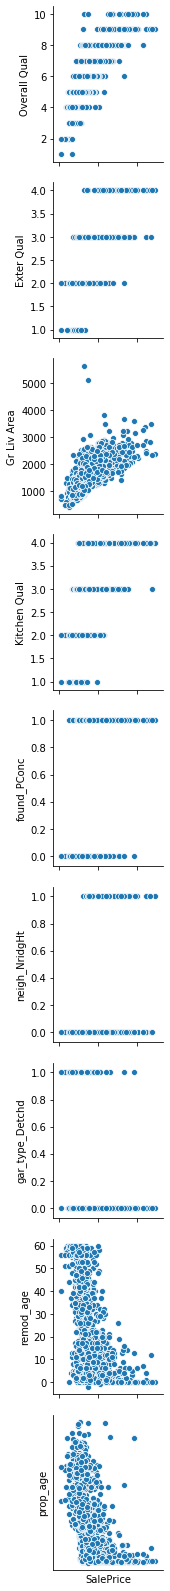

In [11]:
sns.pairplot(train, y_vars=y_vars, x_vars=['SalePrice']);
plt.tick_params(
                axis='both',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                right=False,
                labelbottom=False,  # labels along the bottom edge are off
                labelleft=False)   # labels along the left edge are off
# plt.tick_params(axis='y', 
#                 which='both',      # both major and minor ticks are affected
#                 bottom=False,      # ticks along the bottom edge are off
#                 top=False,         # ticks along the top edge are off
#                 labelleft=False) # labels along the bottom edge are off

`Overall Qual` and `Gr Liv Area` have an increasing trend to them where the higher the overall quality or living area the higher the sale price. `Exter Qual`, `Kitchen Qual`, `Northridge Heights` tend to be higher when the sale price is higher but there are some overlaps. 

Also, there seems to be an inverse linear relationship between age and the sale price. As the age increases, the sale price will decrease. 

### EDA - Histogram of numerical columns

In [12]:
#get the first 58 columns for looking at correlation
first_col = list(train.columns[0:58])
first_col.append('SalePrice')
first_col.remove('Id')
first_col.remove('PID')

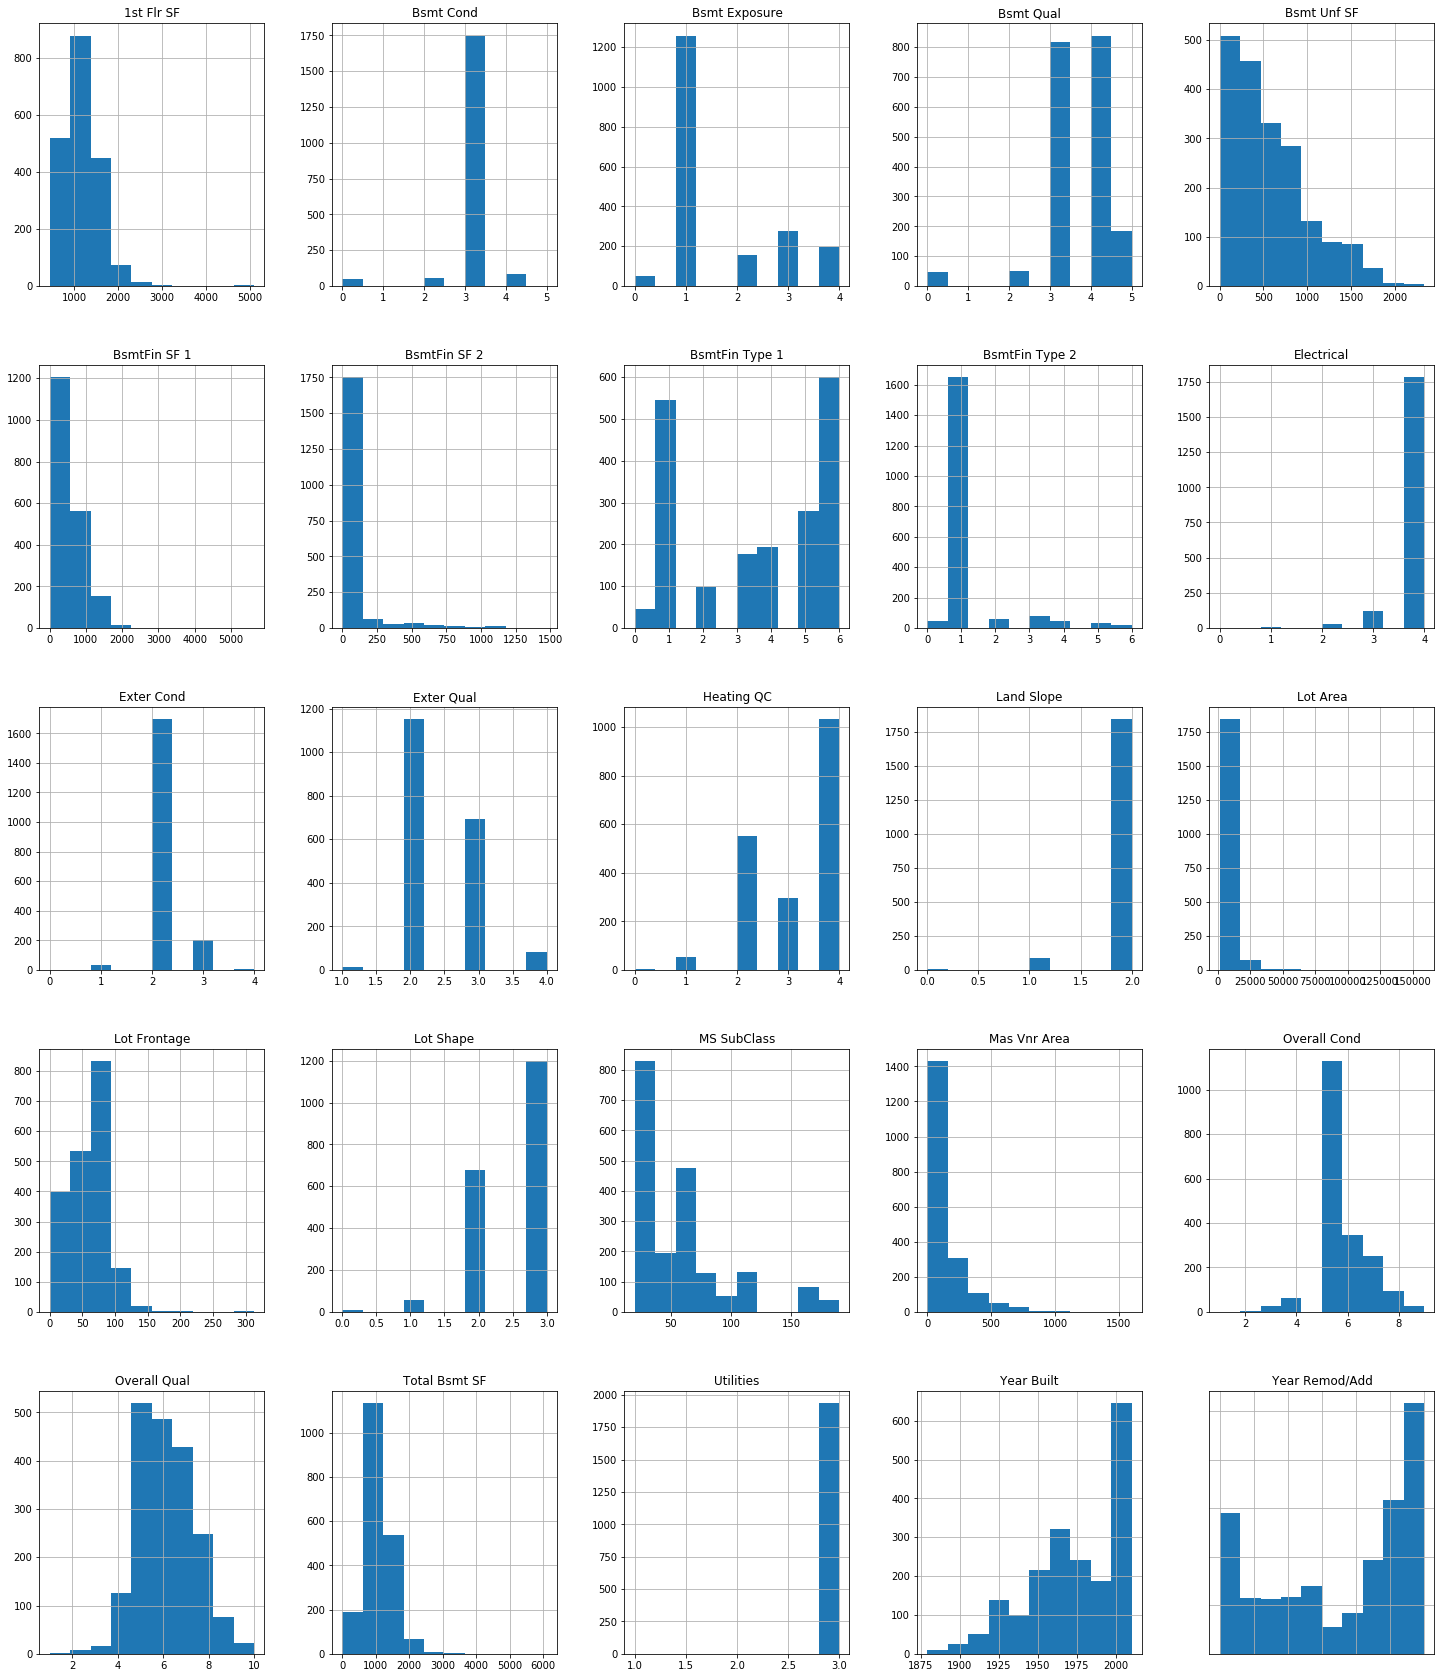

In [13]:
train[first_col[:25]].hist(figsize=(25,30));
plt.tick_params(
                axis='both',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                right=False,
                labelbottom=False,  # labels along the bottom edge are off
                labelleft=False);  

Only `Overal Qual` looks like a normal distribution. 

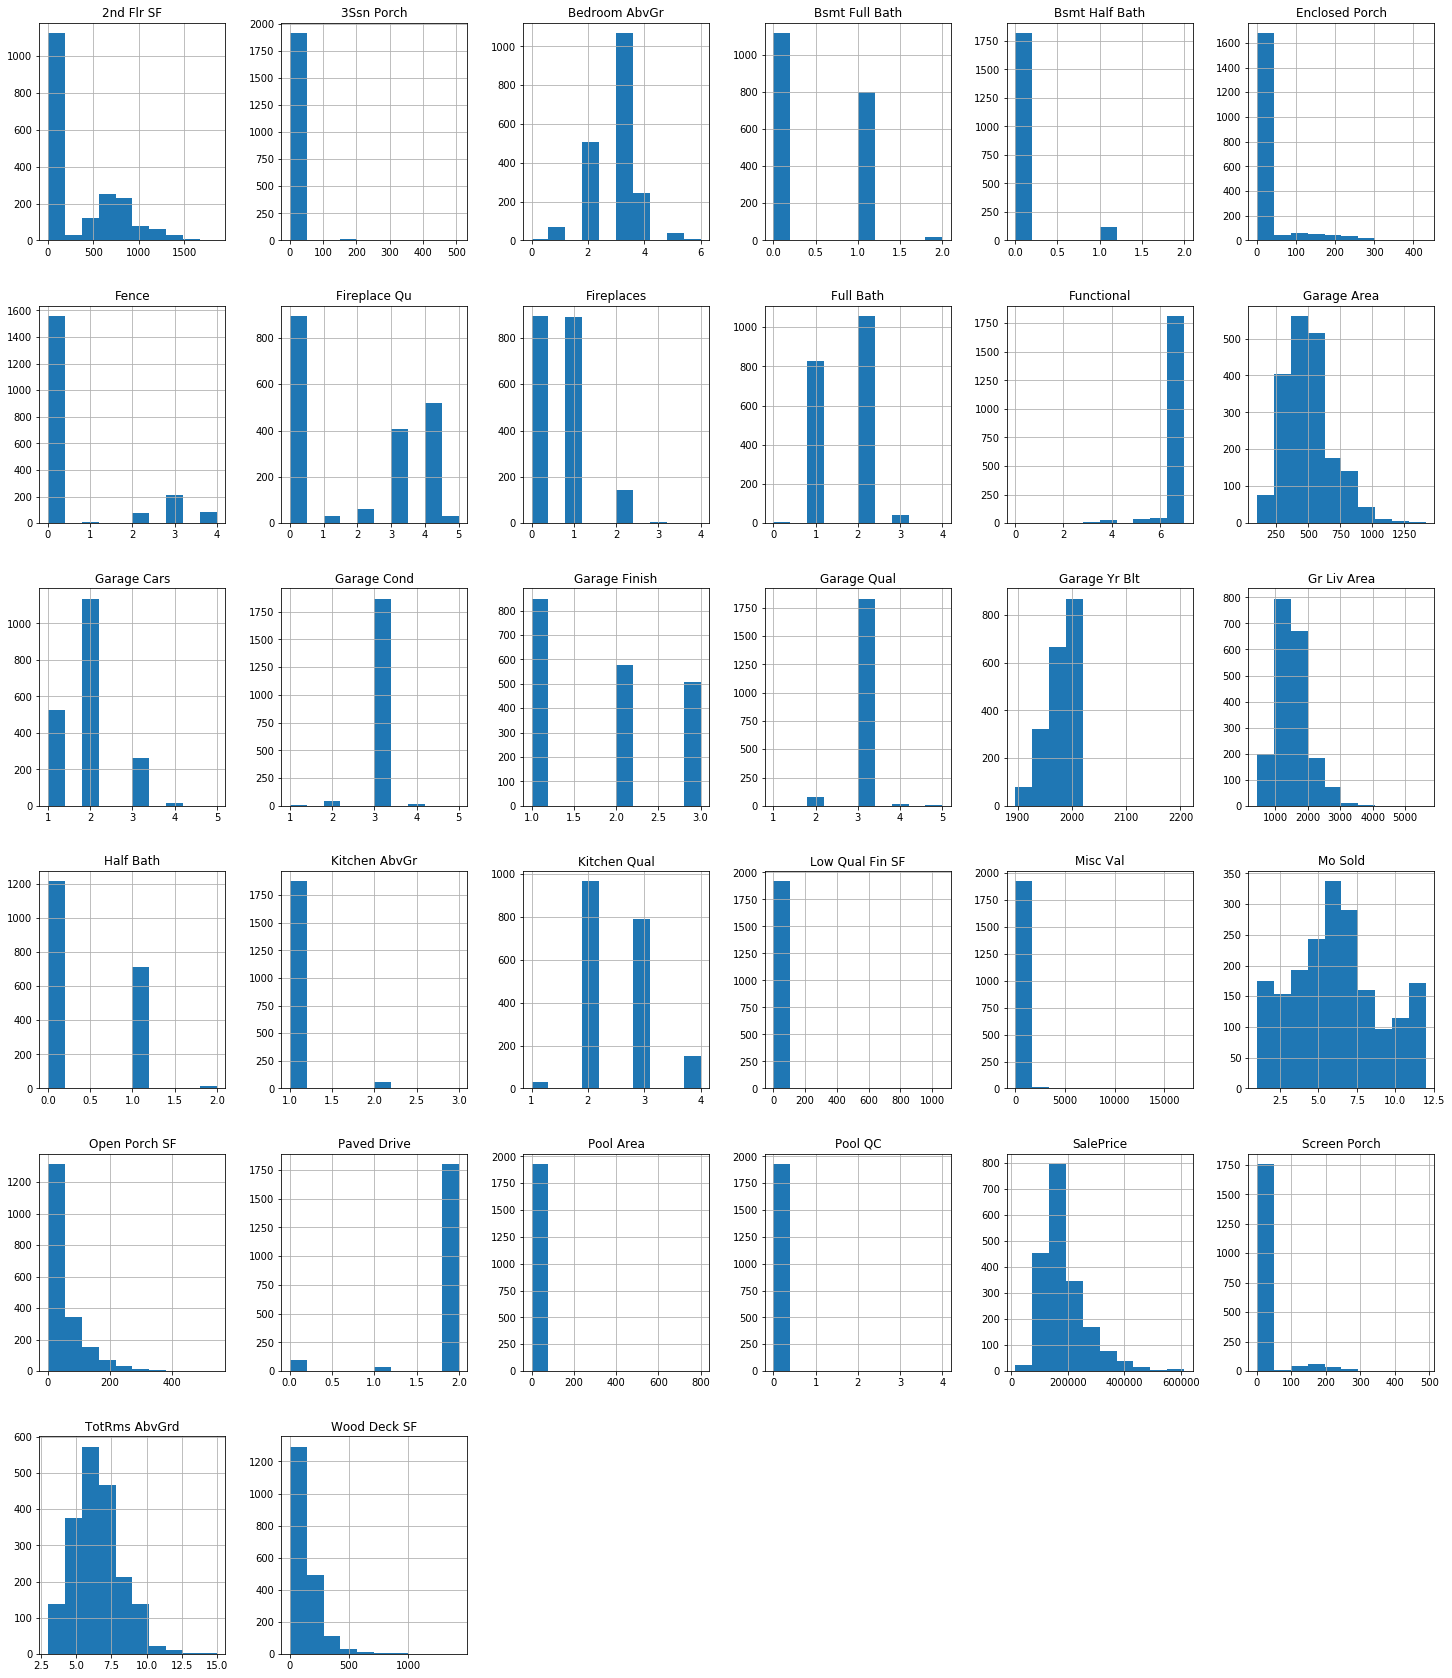

In [14]:
train[first_col[25:]].hist(figsize=(25,30));

We can see that only the `Garage Area`, `Gr Liv Area`, `Mo Sold`, `Sale Price` and `TotRms AbvGrd` columns have largely normally distributed data. ` SalePrice`, `Garage Area`and `Gr Liv Area` are negatively skewed. 

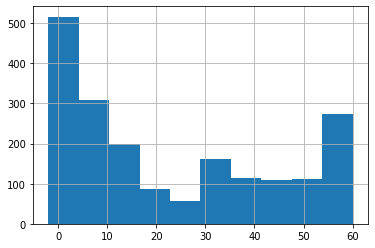

In [15]:
train['remod_age'].hist()

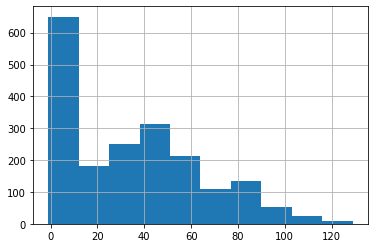

In [16]:
train['prop_age'].hist()

### EDA - Boxplots

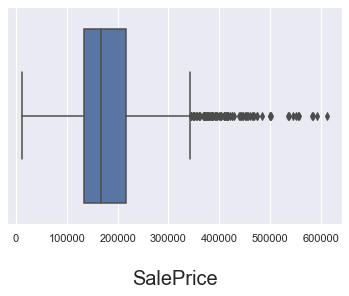

In [17]:
sns.set(font_scale=1)
sns.boxplot(train['SalePrice']);
plt.xlabel('\nSalePrice', fontdict=dict(fontsize=20));

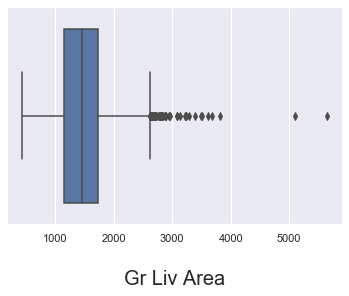

In [18]:
r = sns.boxplot(train['Gr Liv Area']);
plt.xlabel('\nGr Liv Area', fontdict=dict(fontsize=20));

It seems that the `Gr Liv Area` column has 2 distinct outliers. It is worth noting that the median is much lower at about 1500 square feet. 

## Feature Engineering Step 1 - Correlation heatmap

In [20]:
first_cor = train[first_col].corr()

In [21]:
#get correlation larger than 0.2 since there is more relationship here
first_cor = first_cor[first_cor['SalePrice'] > 0.2][['SalePrice']]

In [22]:
first_cor = first_cor.sort_values('SalePrice', ascending=False)

In [23]:
#number of features for correlation > 0.2
len(first_cor.index)

33

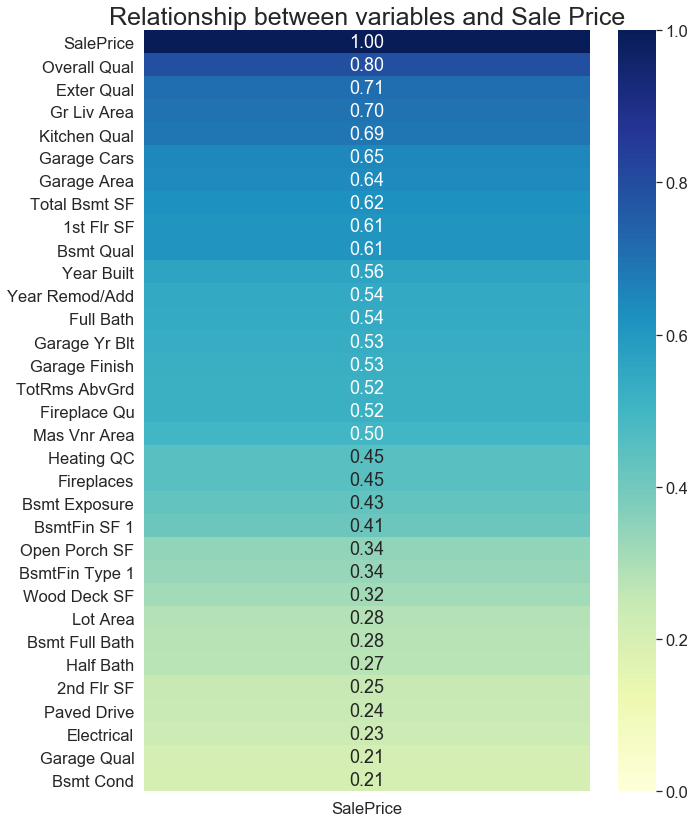

In [24]:
#plot heatmap
sns.set(font_scale=1.5)
plt.figure(figsize=(10,14));
sns.heatmap(first_cor,  vmin=0, vmax=1, cmap='YlGnBu', annot=True, fmt='.2f');
plt.title('Relationship between variables and Sale Price', fontdict={'fontsize':25});

__Positive correlation in first set of columns__

There was nothing special (only very small correlations) to note for the negative correlations for this set of columns. We will look into the positive correlations. 

`Overall Qual` quickly comes to attention with a highest correlation of `0.8` which is expected to be positively correlated with the property price. 
A few quality metrics also stand out such as `Exter Qual (0.71)`, `Bsmt Qual (0.61)`, `Kitchen Qual (0.69)` all having above `0.6` correlations. This shows that these different facets of quality metrics can highly influence the property price. 

Size related features like `Total Bsmt SF`, `1st Flr SF`, `Gr Liv Area`, `TotRms AbvGrd`, `Full Bath` are also highly correlated, as expected. This is very telling that the larger the property and higher the number of rooms and bathrooms, the higher the property price. 

The two garage features `Garage Cars` and `Garage Area` which denotes the size of garage, highly influences the property price as well. This is definitely true for USA since car ownership is very prevalent there. 

Interestingly, people value more how well the house is heated in winter than the size of the property on the second floor. `Heating QC` denoting heating quality and condition has much more influence on the price than the size of the property on the second floor. 

In [25]:
#get the subsequest columns after 59th column for looking at correlation
sec_col = list(train.columns[58:])
sec_cor = train[sec_col].corr()

In [26]:
#number of features for second correlation 
sec_cor.shape

(149, 149)

In [27]:
#get correlation lesser than < -0.2 or > 0.2
sec_cor_neg = sec_cor[(sec_cor['SalePrice'] < -0.2) | (sec_cor['SalePrice'] > 0.2)][['SalePrice']]
sec_cor_neg = sec_cor_neg.sort_values('SalePrice', ascending=False)

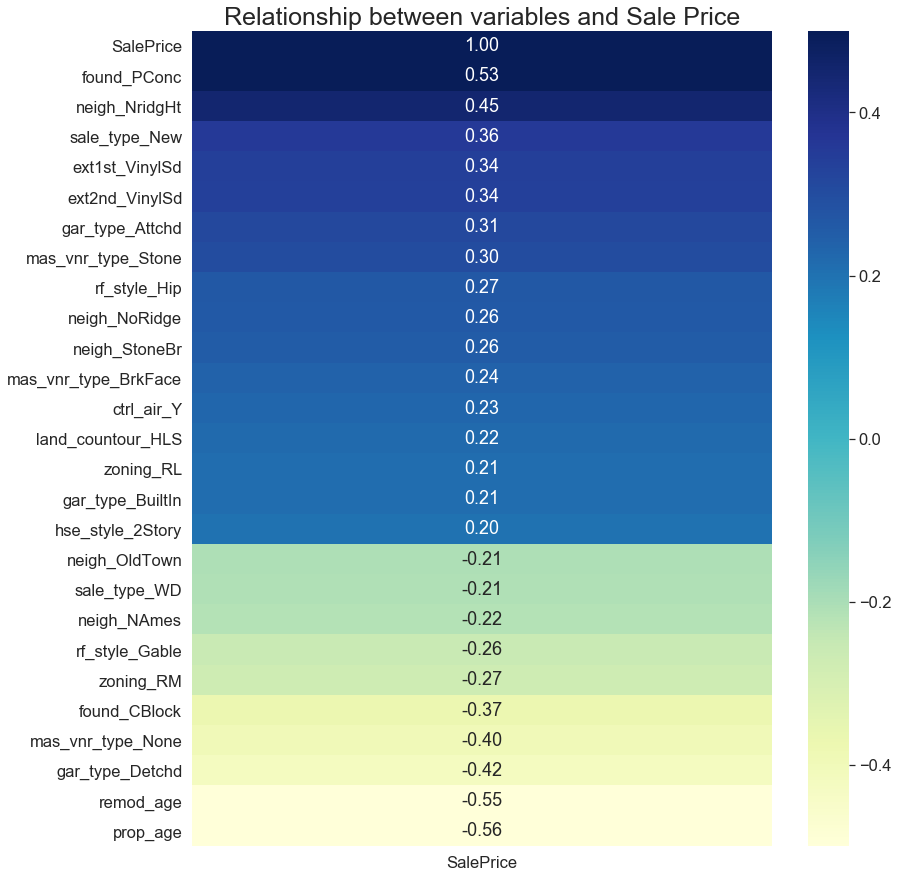

In [28]:
plt.figure(figsize=(13,15));
sns.heatmap(sec_cor_neg, vmin=-0.5, vmax=0.5, cmap='YlGnBu' , annot=True,fmt='.2f');
plt.title('Relationship between variables and Sale Price', fontdict={'fontsize':25});

__Negative correlation on the subsequent set of columns__

The most negatively correlated features are the property age and age since property remodelling. This is no surprise here as the older the property, the lower the price. 

If the garage type is Detached, it lowers the price too and has an inverse relationship with when it has a built in garage.  This makes sense as in times of rain or cold weather, it is more convenient to get to the car. 

It also looks like the properties in the neighbourhoods of Old Town and Nothern Ames are slightly lower in value. 

Interestingly, cinder block foundation (`found_CBlock`) has a negative relationship with price. Whereas poured concrete foundation (`found_PConc`) is on the opposite spectrum with a high positive relationship with price. Cinder block foundation is older and thus more costly to maintain than poured concrete foundation which explains the relationship.

In [29]:
#get positive correlation larger than > 0.2
sec_cor_pos = sec_cor[sec_cor['SalePrice'] > 0.2][['SalePrice']]
sec_cor_pos = sec_cor_pos.sort_values('SalePrice', ascending=False)

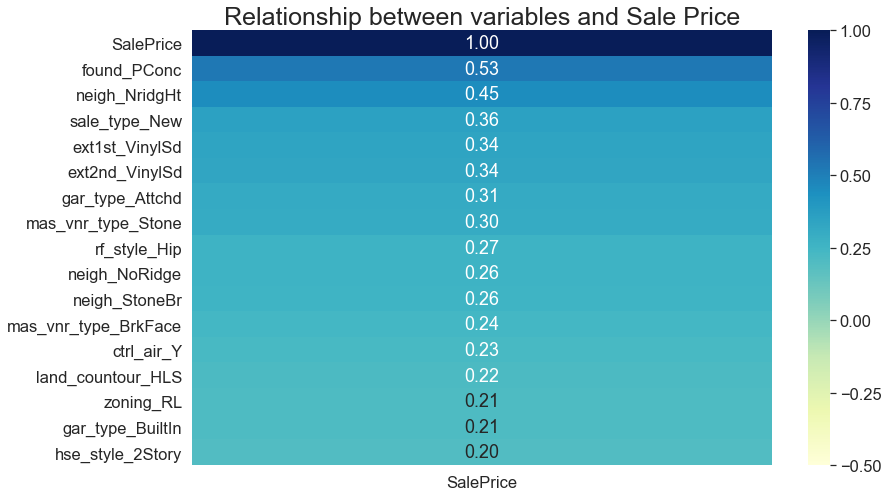

In [30]:
plt.figure(figsize=(13,8));
sns.heatmap(sec_cor_pos, vmin=-0.5, vmax=1, cmap='YlGnBu', annot=True,fmt='.2f');

plt.title('Relationship between variables and Sale Price', fontdict={'fontsize':25});

__Positive correlation on the subsequent columns__

The next highest correlation after concrete foundation is `neigh_NridgeHt` which is the neighbourhood of Northridge Heights. This means that a property there would influence the sale price to be higher. The other neighbourhoods such as Northridge and Stone Brook also positively influence the price, though not as high as Northridge Heights. 

The vinyl material that covers the exterior of the house also is slightly correlated to the price at a correlation value of `0.34`. On the topic of materials, a stone masonry veneer type, brick face masonry veneer type and hip roof style are also closely related to price. 

The interior that is covered by a central air-conditioning also plays apart in its property value, though not super high at a value of `0.23`.

In [31]:
print(len(sec_cor_neg))
len(first_cor)

27


33

In [32]:
interested_feat = [i.strip() for i in sec_cor_neg.index]
interested_feat.extend([i.strip() for i in first_cor.index])
#remove redundant features
interested_feat.remove('SalePrice')
interested_feat.remove('SalePrice')
#remove those year variables that are falsely treated as continous
interested_feat.remove('Year Built')
interested_feat.remove('Year Remod/Add')
interested_feat.remove('Garage Yr Blt')

In [33]:
len(interested_feat)

55

In [34]:
corr_feat = train[interested_feat].corr()
corr_feat = corr_feat[abs(corr_feat) > 0.6]

corr_feat.shape

(55, 55)

In [35]:
#dropping features that have no high correlation for ease of plotting graph
for col in corr_feat.columns:
    if corr_feat[col].isna().sum() == (corr_feat.shape[0]-1):
        corr_feat.drop(col, axis=0, inplace=True)
        corr_feat.drop(col, axis=1, inplace=True)
        

In [36]:
corr_feat.shape

(37, 37)

In [37]:
corr_feat.columns

Index(['found_PConc', 'sale_type_New', 'ext1st_VinylSd', 'ext2nd_VinylSd',
       'gar_type_Attchd', 'rf_style_Hip', 'mas_vnr_type_BrkFace', 'zoning_RL',
       'hse_style_2Story', 'sale_type_WD', 'rf_style_Gable', 'zoning_RM',
       'found_CBlock', 'mas_vnr_type_None', 'gar_type_Detchd', 'remod_age',
       'prop_age', 'Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual',
       'Garage Cars', 'Garage Area', 'Total Bsmt SF', '1st Flr SF',
       'Bsmt Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplace Qu',
       'Mas Vnr Area', 'Fireplaces', 'BsmtFin SF 1', 'BsmtFin Type 1',
       'Bsmt Full Bath', 'Half Bath', '2nd Flr SF', 'Bsmt Cond'],
      dtype='object')

Usually we do not do heatmap for categorical data vs continuous data, so we are only going to look at categorical columns since they are on the same scale. 

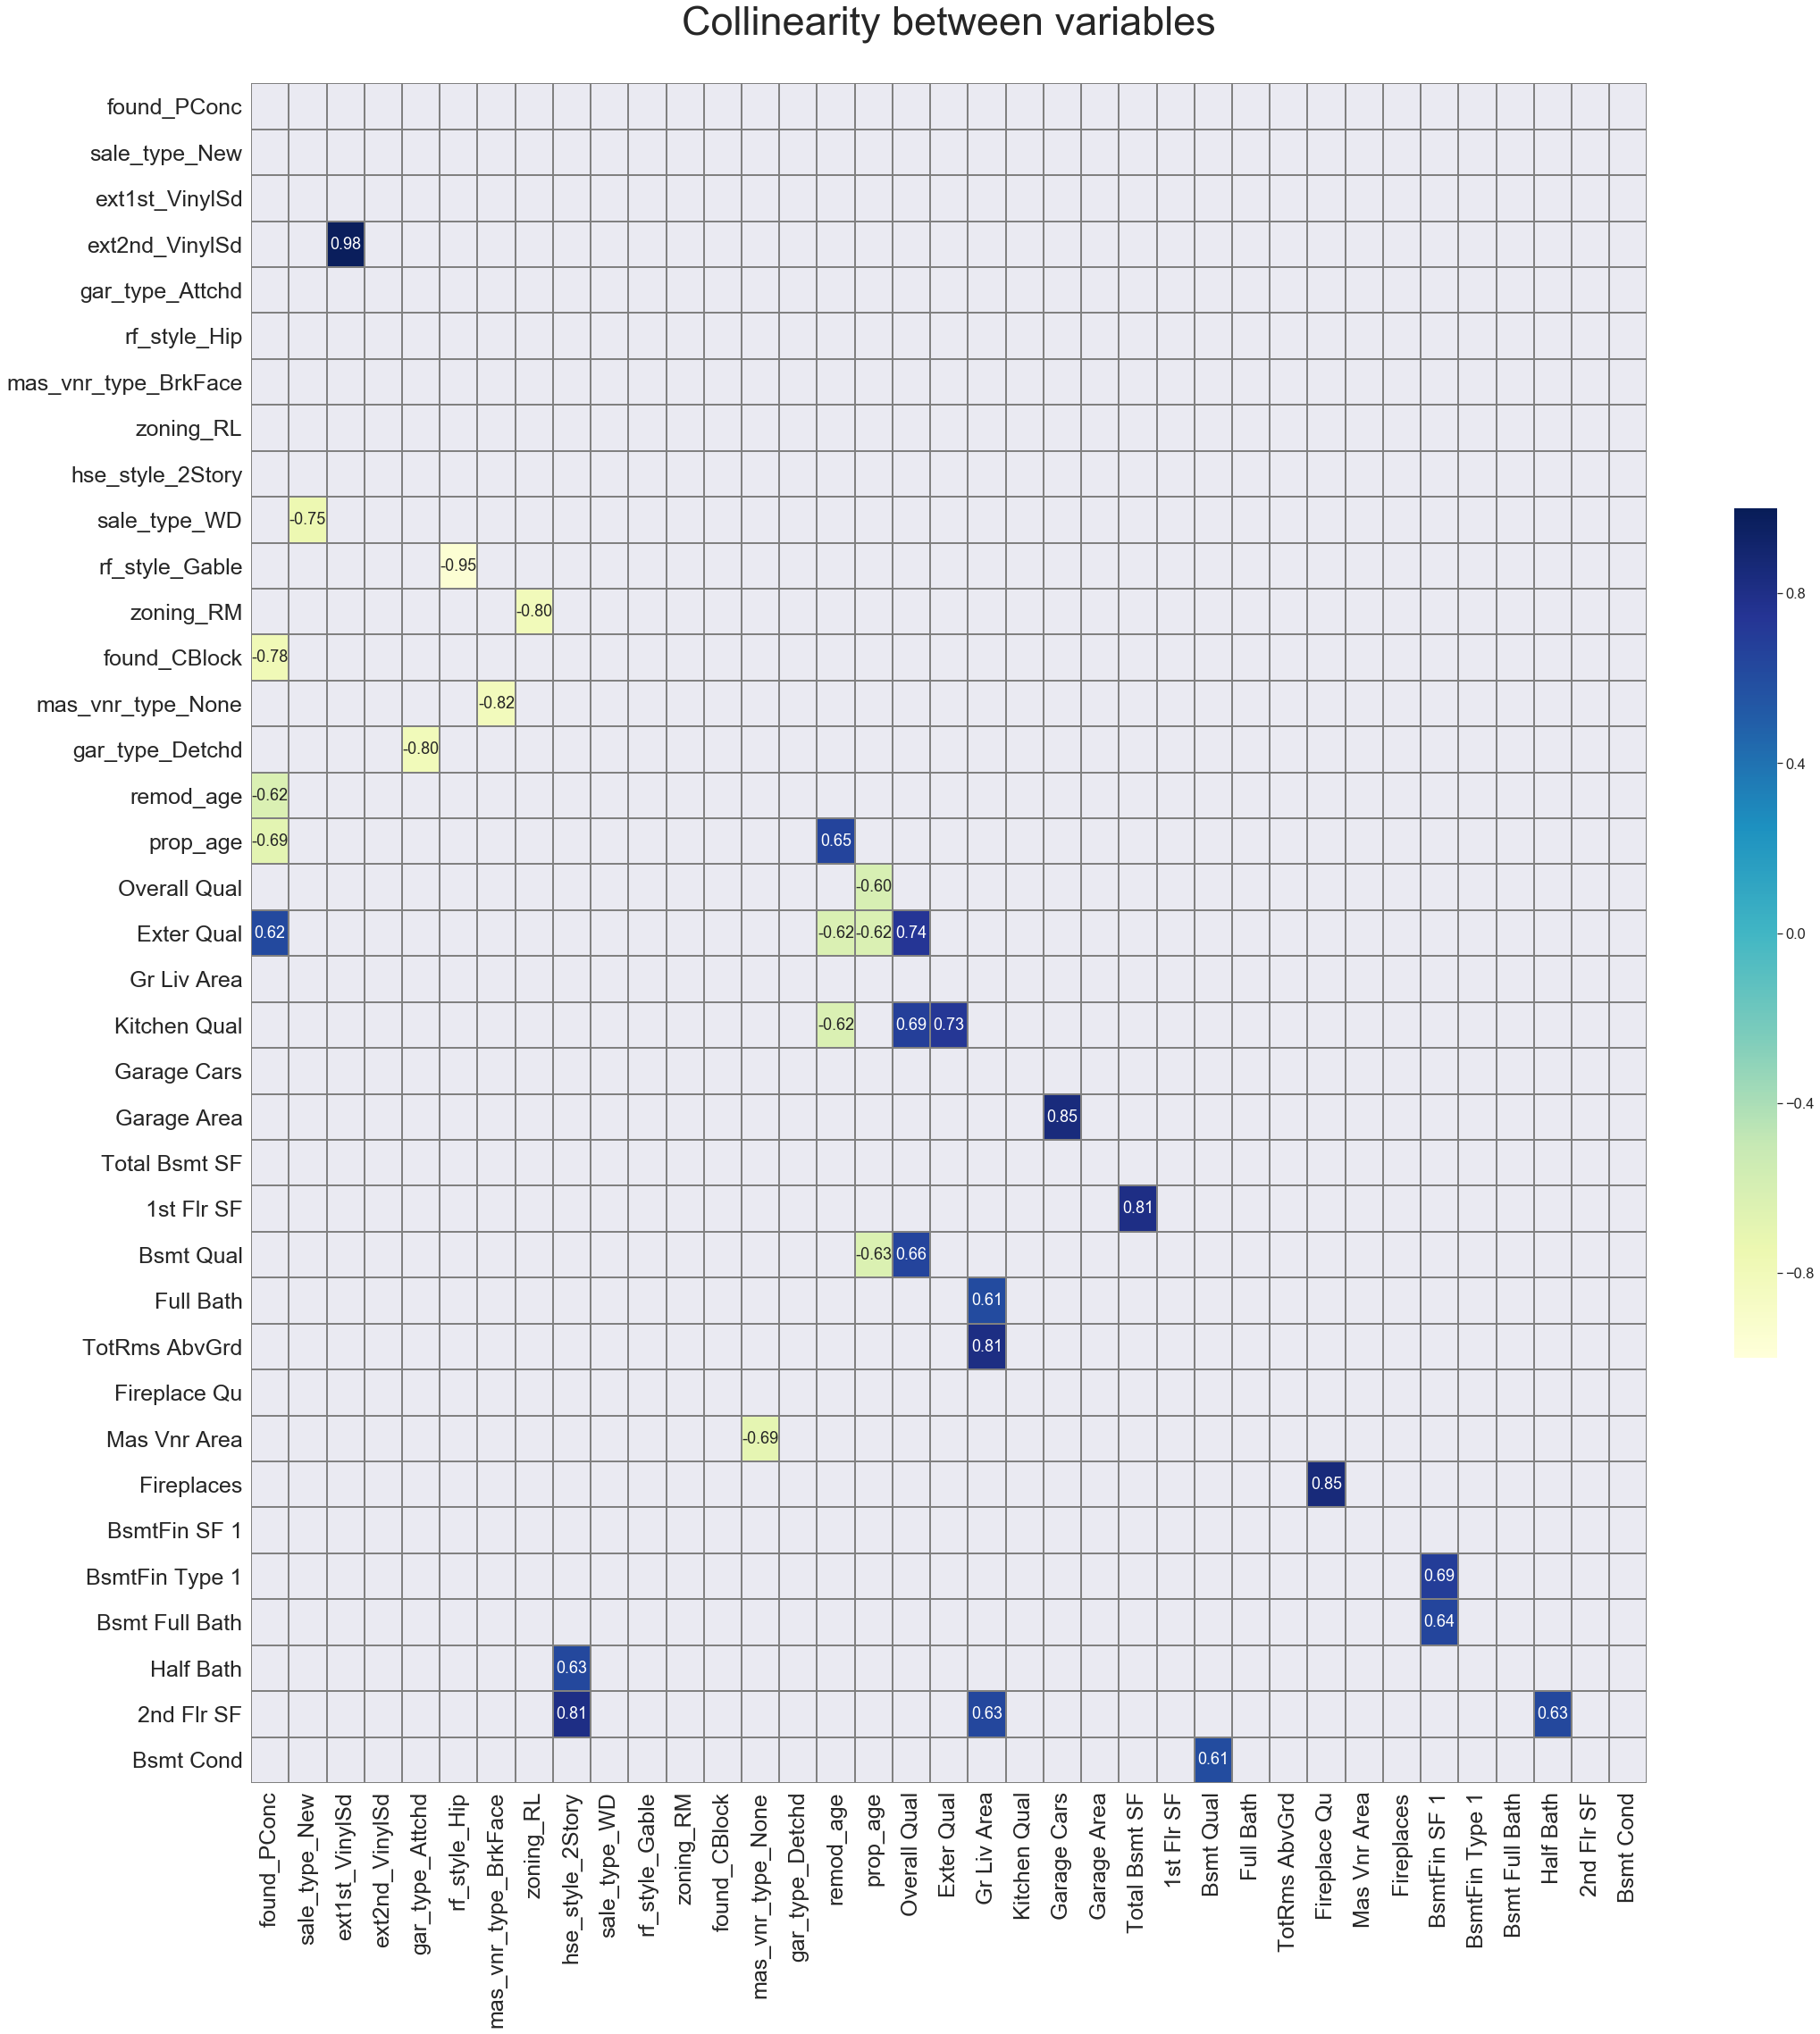

In [38]:
sns.set(font_scale=1.5)
fix, ax = plt.subplots(figsize=(35,35))
mask = np.zeros_like(corr_feat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr_feat, mask=mask, vmin=-1, vmax=1, cmap='YlGnBu', annot=True,fmt='.2f', 
                 linewidths=1, linecolor='grey', cbar_kws={"shrink": 0.5} );#cbar_kws={"shrink": 0.5}
ax.tick_params(labelsize=25)
ax.tick_params(
                axis='x',          # changes apply to the x-axis
                which='major',      # both major and minor ticks are affected     
                labeltop=False,
                labelrotation='default'
)
plt.xticks(rotation='vertical');
plt.title('Collinearity between variables\n', fontdict={'fontsize':45});

In [39]:
if 'hse_style_2story' in interested_feat:
    print (True)

In [40]:
#remove unwanted columns like sale types
interested_feat.remove('sale_type_New')
interested_feat.remove('sale_type_WD')

We will drop `hse_style_2story` because there is already a column, `2nd Flr SF` denoting the same thing. If there it is a 2 story house, it will definitely have a square feet above 0 and vice versa. 

In [41]:
interested_feat.remove('hse_style_2Story') 

For `gar_type_Attchd` and `gar_type_Detchd` columns, they represent if the garage they have is Attached to the house or not. Since they represent the same thing we will drop one of them, `gar_type_Attchd` which has the lowest absolute correlation. This would not affect the relationship between sale price and if the house has a garage or not, as this information is captured by another column `Garage Area`.  

In [42]:
interested_feat.remove('gar_type_Attchd')

For `Garage Area` and `Garage Cars`, they have very high correlation simply because they are representing the same things, we should also drop one of them, `Garage Cars`, since `Garage Area` wholly represents the garage area. 

In [43]:
interested_feat.remove('Garage Cars')

Fireplaces and fireplace quality (`Fireplace Qu`) are representing similar things, except that fireplace quality will encompass both if there is a fireplace and fireplace quality. So we can debate if we would like to drop either columns since they are highly correlated. 

However there is another dimension that Fireplaces can represent, which is if the number of fireplaces influences the house price. Since the correlation of fireplace quality to the sale price is higher, we shall drop `Fireplaces`. 

In [44]:
interested_feat.remove('Fireplaces')

In [45]:
#total interested features in feeding into our model later on
len(interested_feat)

49

## Modelling

### Model prep: Create features and target

In [46]:
features = [col for col in interested_feat if col != 'SalePrice']
X = train[features]
y = train['SalePrice']

In [47]:
len(features)

49

In [48]:
print(X.shape)
y.shape

(1937, 49)


(1937,)

### Model prep: Train/test Split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [50]:
X_train.shape

(1452, 49)

In [51]:
X_test.shape

(485, 49)

### Model prep: Scale data

In [52]:
ss = StandardScaler()
#get the mean and std for training data
ss.fit(X_train) 
X_train = ss.transform(X_train)
#using mean and std of training data for transforming the data for test set
X_test = ss.transform(X_test)

### Actual Modelling

Instantiating of Linear Regression, Lasso Regression and Ridge Regression models. 

In [53]:
lr = LinearRegression()

In [54]:
lasso = LassoCV(n_alphas=500)

In [55]:
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

#### Model comparison

In [56]:
lr_scores = cross_val_score(lr, X_train, y_train, cv=10)
print('Linear Regression R2 Train Score:', lr_scores.mean())

Linear Regression R2 Train Score: 0.7884353658983371


In [57]:
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)

/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silen

In [58]:
print('Lasso Regression R2 Train Score:', lasso_scores.mean())

Lasso Regression R2 Train Score: 0.7936765559203817


In [59]:
lasso.fit(X_train, y_train)

/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=500, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [60]:
print('Lasso Regression R2 Test Score:', lasso.score(X_test, y_test))

Lasso Regression R2 Test Score: 0.8884968760315368


In [61]:
lasso_coef_series = pd.Series(lasso.coef_, index=interested_feat).sort_values(ascending=False)

In [62]:
#number of features after lasso
lasso_coef_series[lasso_coef_series != 0].shape

(41,)

In [63]:
#features and their coefficients after lasso
lasso_coef_series

Overall Qual            16499.191877
Gr Liv Area             12715.775843
neigh_NridgHt            8423.102123
Kitchen Qual             7377.310128
neigh_StoneBr            6771.851973
Exter Qual               6498.545176
Garage Area              5845.180183
Bsmt Exposure            5729.981721
Fireplace Qu             5719.003177
neigh_NoRidge            5168.601666
Lot Area                 4853.462621
rf_style_Hip             4254.173557
TotRms AbvGrd            3740.328642
Bsmt Full Bath           3323.431432
BsmtFin Type 1           3162.127054
land_countour_HLS        2822.452047
Full Bath                2782.048371
1st Flr SF               2644.879390
Mas Vnr Area             2596.541391
Bsmt Qual                2471.565752
mas_vnr_type_None        2287.755987
Garage Qual              1712.488015
Heating QC               1689.524134
BsmtFin SF 1             1510.236064
Total Bsmt SF            1404.868044
Half Bath                1315.180179
ext2nd_VinylSd           1228.952289
G

In [64]:
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)
print('Ridge Regression R2 Train Score:',ridge_scores.mean())

Ridge Regression R2 Train Score: 0.7906238634305376


In [65]:
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [66]:
print('Ridge Regression R2 Test Score:', ridge.score(X_test, y_test))

Ridge Regression R2 Test Score: 0.8868494220051176


In [67]:
ridge_coef_series = pd.Series(ridge.coef_, index=interested_feat).sort_values(ascending=False)

In [68]:
#total number of features from ridge
ridge_coef_series[ridge_coef_series != 0].shape

(49,)

In [69]:
ridge_coef_series[ridge_coef_series != 0]

Overall Qual            16156.406773
mas_vnr_type_None        9555.052656
ext2nd_VinylSd           9181.399406
neigh_NridgHt            8865.786454
Gr Liv Area              7415.488060
Kitchen Qual             7280.169655
neigh_StoneBr            6982.046120
Exter Qual               6556.709852
mas_vnr_type_BrkFace     6442.900814
Bsmt Exposure            6017.036761
rf_style_Hip             5954.247637
Fireplace Qu             5721.681707
neigh_NoRidge            5641.691973
Garage Area              5541.854763
1st Flr SF               5503.825922
mas_vnr_type_Stone       5365.134934
Lot Area                 5141.323488
TotRms AbvGrd            4131.664689
Full Bath                3777.309744
Bsmt Qual                3731.171492
Bsmt Full Bath           3622.947791
BsmtFin Type 1           3466.322584
Mas Vnr Area             3021.770377
2nd Flr SF               2984.328757
land_countour_HLS        2915.351370
prop_age                 2420.423643
Total Bsmt SF            2336.266522
H

All of them have higher scores in test scores than training scores, which is a good sign which shows that the model is not overfitting the training data too much. In the end, __Lasso Regression__ has the best test score of <mark>88.85%</mark>. 

Both Ridge and Lasso Regression have taken `Overall Qual - Overal Quality` as the top predictor of house prices. However, the top 5 predictors are different for both with Lasso Regression looking to have the top 3 to be quite logical. Overall quality of the house, living area in square feet and if the property is situated in Northridge Heights neighbourhood are the top 3 that influence house prices positively. 

| Feature       | Coefficient  | Model |
|---------------|--------------|-------|
| Overall Qual  | 16499.192    | Lasso |
| Gr Liv Area   | 12715.775843 | Lasso |
| neigh_NridgHt | 8423.102123  | Lasso |

Northridge Heights is one of the top neighbourhoods to live in because it is very near amenities and schools (Iowa State University and their mainstream schools). In contrast, `neigh_OldTown - Old Town Neighbourhood` has 0 coefficient after Lasso Regression, which means it does not influence greatly the property price. It is a neighbourhood that is much further away from amenities and schools and is not as convenient. 

## Feature Engineering Step 2: Lasso

There is another way to do feature engineering - to do it through Lasso Regression, a common method in weeding out the irrelevant features. We will now introduce it as a second step since we are not experts in all the features of housing data. 

We can try to throw in all the features we identified earlier on into the model and see what are the columns that are regularised. 

### Model prep: Create features and target

In [70]:
#putting in all the features we identified earlier on
features = [i for i in interested_feat if i != 'SalePrice']
X = train[features]
y = train['SalePrice']

In [71]:
X.shape

(1937, 49)

### Model prep: Train/test Split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Model prep: Scale data

In [73]:
#scale the data
ss = StandardScaler()
ss.fit(X_train) #get the mean and std
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

### Feature engineering modelling

In [74]:
#use a very high alpha to introduce a high penalty term
lasso = LassoCV(n_alphas=9000)

In [75]:
lasso.fit(X_train, y_train)

/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=9000, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [76]:
lasso_coef_features = pd.Series(lasso.coef_, index=features).sort_values(ascending=False)

Features deemed to be not influential on the housing price (total of 8):

In [77]:
lasso_coef_features[lasso_coef_features == 0].sort_index().index

Index(['2nd Flr SF', 'ext1st_VinylSd', 'found_CBlock', 'gar_type_Detchd',
       'mas_vnr_type_BrkFace', 'neigh_NAmes', 'neigh_OldTown',
       'rf_style_Gable'],
      dtype='object')

In [78]:
new_feat = [i for i in lasso_coef_features.index if i not in 
            list(lasso_coef_features[lasso_coef_features == 0].index)]

Total number of relevant features chosen by Lasso Regression:

In [79]:
len(new_feat)

41

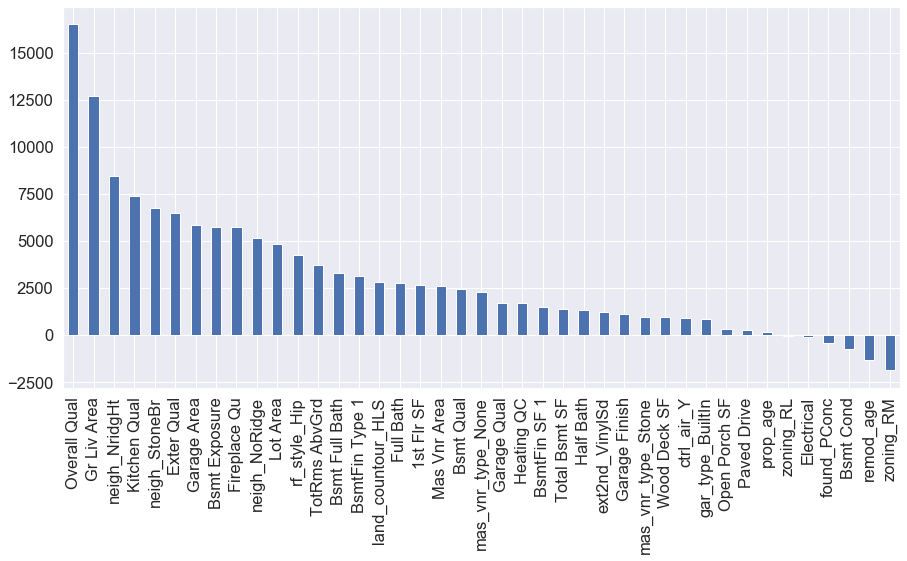

In [80]:
lasso_coef_features[new_feat].plot.bar(figsize=(15,7))

In [81]:
lasso_coef_features[new_feat]

Overall Qual          16498.957182
Gr Liv Area           12705.131815
neigh_NridgHt          8425.107297
Kitchen Qual           7377.432147
neigh_StoneBr          6773.340055
Exter Qual             6498.223030
Garage Area            5844.379558
Bsmt Exposure          5731.777987
Fireplace Qu           5719.151640
neigh_NoRidge          5171.423961
Lot Area               4853.953797
rf_style_Hip           4255.342033
TotRms AbvGrd          3742.645031
Bsmt Full Bath         3324.578129
BsmtFin Type 1         3164.237671
land_countour_HLS      2823.165171
Full Bath              2787.687091
1st Flr SF             2647.937737
Mas Vnr Area           2598.973845
Bsmt Qual              2477.125888
mas_vnr_type_None      2291.841478
Garage Qual            1713.540955
Heating QC             1689.899719
BsmtFin SF 1           1508.892148
Total Bsmt SF          1407.425139
Half Bath              1320.432438
ext2nd_VinylSd         1233.924469
Garage Finish          1122.064182
mas_vnr_type_Stone  

Now let's run it one more time to ensure we bring down the number of features further:

In [82]:
X = train[new_feat]
y = train['SalePrice']

In [83]:
X.shape

(1937, 41)

### Model prep: Train/test Split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Model prep: Scale data

In [85]:
#scale the data
ss = StandardScaler()
ss.fit(X_train) #get the mean and std
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

### Actual modelling

In [86]:
#we now use the alpha we used earlier on
lasso = LassoCV(n_alphas=500, cv=10)

In [87]:
lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=500, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [88]:
lasso_fe_2_coef = pd.Series(lasso.coef_, index=new_feat).sort_values(ascending=False)

Features deemed to be not influential on the housing price and further cut the features by another __10__:

In [89]:
lasso_fe_2_coef[lasso_fe_2_coef == 0].shape

(10,)

In [90]:
lasso_fe_2_coef[lasso_fe_2_coef != 0].shape

(31,)

In [91]:
#assign it to the final features
final_features = lasso_fe_2_coef[lasso_fe_2_coef != 0].index
final_features

Index(['Overall Qual', 'Gr Liv Area', 'neigh_NridgHt', 'Kitchen Qual',
       'Exter Qual', 'Garage Area', 'neigh_StoneBr', 'Fireplace Qu',
       'Bsmt Exposure', 'Lot Area', 'neigh_NoRidge', 'rf_style_Hip',
       'TotRms AbvGrd', 'Bsmt Full Bath', 'BsmtFin Type 1', 'Bsmt Qual',
       'land_countour_HLS', 'BsmtFin SF 1', '1st Flr SF', 'Full Bath',
       'Garage Finish', 'Heating QC', 'Mas Vnr Area', 'Garage Qual',
       'Total Bsmt SF', 'Wood Deck SF', 'ext2nd_VinylSd', 'ctrl_air_Y',
       'gar_type_BuiltIn', 'remod_age', 'zoning_RM'],
      dtype='object')

## Model prep: Initialise variables

In [92]:
#prepare our X and Y
X = train[final_features]
y = train['SalePrice']

In [93]:
X.shape

(1937, 31)

## Model prep: Train/test Split

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Lasso Regression: Find optimum alpha

In [95]:
# alphas = 10**np.linspace(6,-2,50)*0.5
alphas = np.logspace(-1, 10, 100)
alphas

array([1.00000000e-01, 1.29154967e-01, 1.66810054e-01, 2.15443469e-01,
       2.78255940e-01, 3.59381366e-01, 4.64158883e-01, 5.99484250e-01,
       7.74263683e-01, 1.00000000e+00, 1.29154967e+00, 1.66810054e+00,
       2.15443469e+00, 2.78255940e+00, 3.59381366e+00, 4.64158883e+00,
       5.99484250e+00, 7.74263683e+00, 1.00000000e+01, 1.29154967e+01,
       1.66810054e+01, 2.15443469e+01, 2.78255940e+01, 3.59381366e+01,
       4.64158883e+01, 5.99484250e+01, 7.74263683e+01, 1.00000000e+02,
       1.29154967e+02, 1.66810054e+02, 2.15443469e+02, 2.78255940e+02,
       3.59381366e+02, 4.64158883e+02, 5.99484250e+02, 7.74263683e+02,
       1.00000000e+03, 1.29154967e+03, 1.66810054e+03, 2.15443469e+03,
       2.78255940e+03, 3.59381366e+03, 4.64158883e+03, 5.99484250e+03,
       7.74263683e+03, 1.00000000e+04, 1.29154967e+04, 1.66810054e+04,
       2.15443469e+04, 2.78255940e+04, 3.59381366e+04, 4.64158883e+04,
       5.99484250e+04, 7.74263683e+04, 1.00000000e+05, 1.29154967e+05,
      

In [96]:
lassocv = LassoCV(alphas=alphas, cv=10, max_iter=100000)

In [97]:
lassocv.fit(X_train, y_train)
print("Alpha =", lassocv.alpha_)
print("Train R2 Score: ", lassocv.score(X_train, y_train))
print("RMSE = ", np.sqrt(metrics.mean_squared_error(y_test, lassocv.predict(X_test))))
print("best model coefficients:")
lasso_coef = pd.Series(lassocv.coef_, index=X.columns).sort_values(ascending=False)
lasso_coef

Alpha = 0.1
Train R2 Score:  0.8379633390687761
RMSE =  27018.732105540756
best model coefficients:


neigh_StoneBr        50500.544826
neigh_NridgHt        36070.577736
neigh_NoRidge        34720.130692
land_countour_HLS    15006.434237
Overall Qual         11699.353753
Exter Qual           11323.478824
Kitchen Qual         11229.191447
rf_style_Hip         10446.803627
Garage Qual           8121.287729
Bsmt Full Bath        6635.716992
Bsmt Exposure         5119.197456
ctrl_air_Y            4905.578344
Full Bath             3935.628035
gar_type_BuiltIn      3854.245420
Fireplace Qu          3201.439954
ext2nd_VinylSd        2943.713863
TotRms AbvGrd         2475.797393
Bsmt Qual             2316.049473
Heating QC            1770.737849
BsmtFin Type 1        1344.810009
Garage Finish         1326.618598
Garage Area             31.525610
Gr Liv Area             28.526436
Mas Vnr Area             7.910087
Wood Deck SF             7.704353
1st Flr SF               5.224515
BsmtFin SF 1             3.979550
Total Bsmt SF            2.318467
Lot Area                 0.694518
remod_age     

In [98]:
print("Lasso final Test R2 Score: ", lassocv.score(X_test, y_test))

Lasso final Test R2 Score:  0.8879385777257951


In [99]:
lasso_pred = lassocv.predict(X_test)
lasso_residuals = y_test - lasso_pred

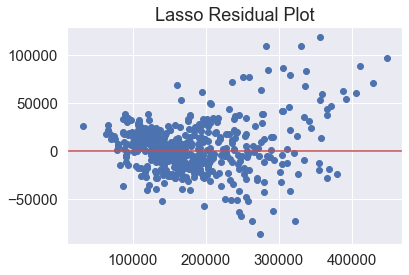

In [100]:
plt.scatter(lasso_pred, lasso_residuals);
plt.axhline(0, color='r');
plt.title("Lasso Residual Plot");
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

## Ridge Regression: Find optimum alpha

In [139]:
ridge_alphas = np.logspace(0, 150, 200)
ridgecv = RidgeCV(alphas=ridge_alphas, cv=10)
ridgecv.fit(X_train, y_train)
print("Alpha =", ridgecv.alpha_)
print("Train R2 Score: ", ridgecv.score(X_train, y_train))
print("RMSE = ", np.sqrt(metrics.mean_squared_error(y_test, ridgecv.predict(X_test))))

Alpha = 1.0
Train R2 Score:  0.8379422763973675
RMSE =  26990.667589511235


/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [102]:
print("best model coefficients:")
pd.Series(ridgecv.coef_, index=X.columns).sort_values(ascending=False)

best model coefficients:


neigh_StoneBr        48313.859039
neigh_NridgHt        35155.901152
neigh_NoRidge        33220.496702
land_countour_HLS    15046.787455
Overall Qual         11766.228376
Exter Qual           11378.571186
Kitchen Qual         11259.692702
rf_style_Hip         10453.894531
Garage Qual           7949.499484
Bsmt Full Bath        6643.571224
Bsmt Exposure         5104.294386
ctrl_air_Y            4747.726301
gar_type_BuiltIn      3999.516988
Full Bath             3884.401195
Fireplace Qu          3203.216056
ext2nd_VinylSd        2911.079051
TotRms AbvGrd         2471.051519
Bsmt Qual             2329.864821
Heating QC            1777.593005
BsmtFin Type 1        1354.618455
Garage Finish         1318.202606
Garage Area             31.717965
Gr Liv Area             28.619429
Mas Vnr Area             8.318455
Wood Deck SF             7.780179
1st Flr SF               5.256285
BsmtFin SF 1             3.959800
Total Bsmt SF            2.350408
Lot Area                 0.691840
remod_age     

In [103]:
print("Ridge R2 Test Score", ridgecv.score(X_test, y_test))

Ridge R2 Test Score 0.888171254539097


In [104]:
ridge_pred = ridgecv.predict(X_test)
ridge_residuals = y_test - ridge_pred

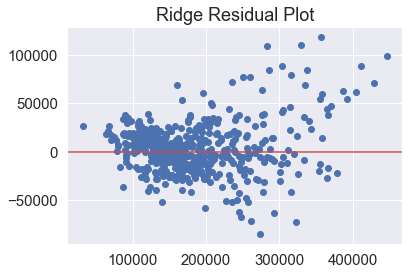

In [105]:
plt.scatter(ridge_pred, ridge_residuals);
plt.axhline(0, color='r');
plt.title("Ridge Residual Plot");
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

## Elasticnet: Find optimum parameters

In [106]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=10,
                            verbose=1)
optimal_enet.fit(X_train, y_train)

print ("Alpha: ",optimal_enet.alpha_)
print ("l1 ration:", optimal_enet.l1_ratio_)
print("Train R2 Score: ", optimal_enet.score(X_train, y_train))
print("RMSE = ", np.sqrt(metrics.mean_squared_error(y_test, optimal_enet.predict(X_test))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Alpha:  0.1
l1 ration: 1.0
Train R2 Score:  0.8379633390687761
RMSE =  27018.732105540756


............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   11.0s finished


In [107]:
print("Elasticnet R2 test score:", optimal_enet.score(X_test, y_test))

Elasticnet R2 test score: 0.8879385777257951


In [108]:
enet_pred = optimal_enet.predict(X_test)
enet_residuals = y_test - enet_pred

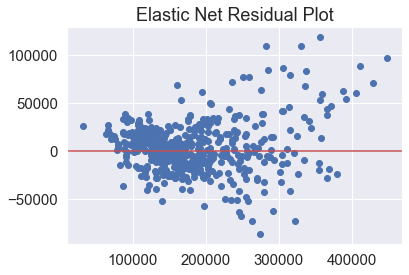

In [109]:
plt.scatter(enet_pred, enet_residuals);
plt.axhline(0, color='r');
plt.title("Elastic Net Residual Plot");
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

## Model comparison

Ridge regression by far has the best test score yet at <mark>88.82%</mark>. With 31 features now, it is now more ideal and easy to explain to relevant stakeholders. Ideally we would always want to have a model that is complex enough to fit all the points but still having enough simplicity to explain your model. 

Additionally, the Ridge Regression model does not look to be overfitted as they perform better on the test score. 

### Residual plot analysis

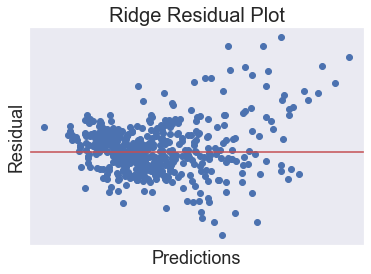

In [110]:
plt.scatter(lasso_pred, ridge_residuals);
plt.axhline(0, color='r');
plt.title("Ridge Residual Plot", fontsize=20);
plt.xticks([]);
plt.yticks([]);
plt.xlabel('Predictions');
plt.ylabel('Residual');

In terms of Scedasticity, we want a consistent variance between our low predictions and our high predictions (homoscedasticity). It is leaning towards heteroscedasticity, this means that many of the points are overlapping each other towards the centre.  

## Conclusions

### Top 5 features from final Ridge Regression model 

The top feature that highly influences the price at a coefficient of 48313.86 is a property located at Stone Brooks neighbourhood. It is no wonder the best predictor as this neighbourhood is very convenient and is the closest to Iowa State University, the largest university in Iowa state. [[1]](https://en.wikipedia.org/wiki/Iowa_State_University) It is also very close to downtown and is just about a 10 minute drive away. The other two neighbourhoods, Northridge Heights and Northridge are situated close together and is slightly further away to then University but is equidistant to downtown as compared to Stone Brook neighbourhood. 
Moreover all three neighbourhoods are very close to elementary, middle and high schools and have amenities really close by. [[2]](https://www.google.com/maps/dir/304+Main+Street,+Ames,+IA/Northridge+Lane,+Ames,+IA/@42.0286767,-93.6589652,14.28z/data=!4m14!4m13!1m5!1m1!1s0x87ee7079a7344bb5:0xda5a2e61aea06f0d!2m2!1d-93.614092!2d42.024838!1m5!1m1!1s0x87ee70c37ac346ef:0x5c6a8eb7cb2ce524!2m2!1d-93.6467454!2d42.0478309!3e0?hl=en-US)

However, it is interesting to note that the land contour that is hilly is valued more than the other land contour features. It is perhaps has a good privacy rating among home dwellers in Ames. 

At number five, Overall Quality of the property takes the spot and is no suprise that it is one of the top predictors in property prices, though the coefficient is much lower than being in the top three neighbourhoods. 


| Feature       | Coefficient  | Model |
|---------------|--------------|-------|
| neigh_StoneBr | 48313.86    | Ridge Regression |
| neigh_NridgHt | 35155.90    | Ridge Regression|
| neigh_NoRidge | 33220.50    | Ridge Regression |
| land_countour_HLS | 15046.79| Ridge Regression |
| Overall Qual | 11766.23    | Ridge Regression |

Therefore, we can conclude that having a property in those top three neighbourhoods is way more important in highly influencing property prices than Overall Quality. 

### Recommendations & caveats 

It is important to note that the above conclusions are only based on the Ames housing dataset. More granular analysis is not possible as the data provided are actual sale prices of houses. In order to complement the above findings, more granular data such as buyer data and coordinates of home sales would be beneficial to delve deep into analysis such as buyer behaviour or neighbourhood studies. This could enable home owners or property developers to better target buyers, or to even educate buyers on the kind of houses they should look out for. 

With the right data, it can potentially be an exciting area to look into. 

# Predict from test set

In [161]:
test = pd.read_csv('./datasets/clean_test_encoded.csv')

In [162]:
#calculate age of property
test['prop_age'] = test['Yr Sold'] - test['Year Built']
#calculate age since Remodel date
test['remod_age'] = test['Yr Sold'] - test['Year Remod/Add']

In [163]:
test.columns = [col.strip() for col in test.columns]

In [164]:
test.head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,Mo Sold,Yr Sold,zoning_C,zoning_FV,zoning_I,zoning_RH,zoning_RL,zoning_RM,street_Pave,land_countour_HLS,land_countour_Low,land_countour_Lvl,lot_conf_CulDSac,lot_conf_FR2,lot_conf_FR3,lot_conf_Inside,neigh_Blueste,neigh_BrDale,neigh_BrkSide,neigh_ClearCr,neigh_CollgCr,neigh_Crawfor,neigh_Edwards,neigh_Gilbert,neigh_Greens,neigh_GrnHill,neigh_IDOTRR,neigh_Landmrk,neigh_MeadowV,neigh_Mitchel,neigh_NAmes,neigh_NPkVill,neigh_NWAmes,neigh_NoRidge,neigh_NridgHt,neigh_OldTown,neigh_SWISU,neigh_Sawyer,neigh_SawyerW,neigh_Somerst,neigh_StoneBr,neigh_Timber,neigh_Veenker,cond1_Feedr,cond1_Norm,cond1_PosA,cond1_PosN,cond1_RRAe,cond1_RRAn,cond1_RRNe,cond1_RRNn,cond2_Feedr,cond2_Norm,cond2_PosA,cond2_PosN,cond2_RRAe,cond2_RRAn,cond2_RRNn,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,hse_style_1.5Unf,hse_style_1Story,hse_style_2.5Fin,hse_style_2.5Unf,hse_style_2Story,hse_style_SFoyer,hse_style_SLvl,rf_style_Gable,rf_style_Gambrel,rf_style_Hip,rf_style_Mansard,rf_style_Shed,rf_mat_CompShg,rf_mat_Membran,rf_mat_Metal,rf_mat_Roll,rf_mat_Tar&Grv,rf_mat_WdShake,rf_mat_WdShngl,ext1st_AsphShn,ext1st_BrkComm,ext1st_BrkFace,ext1st_CBlock,ext1st_CemntBd,ext1st_HdBoard,ext1st_ImStucc,ext1st_MetalSd,ext1st_Plywood,ext1st_PreCast,ext1st_Stone,ext1st_Stucco,ext1st_VinylSd,ext1st_Wd Sdng,ext1st_WdShing,ext2nd_AsphShn,ext2nd_Brk Cmn,ext2nd_BrkFace,ext2nd_CBlock,ext2nd_CmentBd,ext2nd_HdBoard,ext2nd_ImStucc,ext2nd_MetalSd,ext2nd_Other,ext2nd_Plywood,ext2nd_PreCast,ext2nd_Stone,ext2nd_Stucco,ext2nd_VinylSd,ext2nd_Wd Sdng,ext2nd_Wd Shng,mas_vnr_type_BrkFace,mas_vnr_type_CBlock,mas_vnr_type_None,mas_vnr_type_Stone,found_CBlock,found_PConc,found_Slab,found_Stone,found_Wood,heat_GasA,heat_GasW,heat_Grav,heat_OthW,heat_Wall,ctrl_air_Y,gar_type_Attchd,gar_type_Basment,gar_type_BuiltIn,gar_type_CarPort,gar_type_Detchd,gar_type_None,misc_feat_Gar2,misc_feat_None,misc_feat_Othr,misc_feat_Shed,misc_feat_TenC,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD,prop_age,remod_age
0,2658,902301120,190,69.0,9142,3,3,2,6,8,1910,1950,0.0,2,1,2,3,1,1,0.0,1,0.0,1020.0,1020.0,3,1,908,1020,0,1928,0.0,0.0,2,0,4,2,1,9,7,0,0,1910,1,1.0,440.0,1,1,2,0,60,112,0,0,0,0,0,0,4,2006,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,96,56
1,2718,905108090,90,0.0,9662,2,3,2,5,4,1977,1977,0.0,2,2,4,3,1,1,0.0,1,0.0,1967.0,1967.0,2,4,1967,0,0,1967,0.0,0.0,2,0,6,2,2,10,7,0,0,1977,3,2.0,580.0,3,3,2,170,0,0,0,0,0,0,0,0,8,2006,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,29,29
2,2414,528218130,60,58.0,17104,2,3,2,7,5,2006,2006,0.0,3,2,4,4,3,6,554.0,1,0.0,100.0,654.0,4,4,664,832,0,1496,1.0,0.0,2,1,3,1,3,7,7,1,4,2006,2,2.0,426.0,3,3,2,100,24,0,0,0,0,0,0,0,9,2006,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0

In [165]:
X = test[final_features]

In [166]:
X.head()

,Overall Qual,Gr Liv Area,neigh_NridgHt,Kitchen Qual,Exter Qual,Garage Area,neigh_StoneBr,Fireplace Qu,Bsmt Exposure,Lot Area,neigh_NoRidge,rf_style_Hip,TotRms AbvGrd,Bsmt Full Bath,BsmtFin Type 1,Bsmt Qual,land_countour_HLS,BsmtFin SF 1,1st Flr SF,Full Bath,Garage Finish,Heating QC,Mas Vnr Area,Garage Qual,Total Bsmt SF,Wood Deck SF,ext2nd_VinylSd,ctrl_air_Y,gar_type_BuiltIn,remod_age,zoning_RM
0,6,1928,0,1,2,440.0,0,0,1,9142,0,0,9,0.0,1,2,0,0.0,908,2,1,3,0.0,1,1020.0,0,0,0,0,56,1
1,5,1967,0,2,2,580.0,0,0,1,9662,0,0,10,0.0,1,4,0,0.0,1967,2,3,2,0.0,3,1967.0,170,0,1,0,29,0
2,7,1496,0,3,3,426.0,0,4,3,17104,0,0,7,1.0,6,4,0,554.0,664,2,2,4,0.0,3,654.0,100,1,1,0,0,0
3,5,968,0,2,3,480.0,0,0,1,8520,0,0,5,0.0,1,3,0,0.0,968,1,1,2,0.0,2,968.0,0,0,1,0,1,1
4,6,1394,0,2,2,514.0,0,4,1,9500,0,0,6,1.0,4,4,0,609.0,1394,1,2,3,247.0,3,1394.0,0,0,1,0,46,0


In [167]:
X.shape

(879, 31)

In [168]:
X_train.shape

(1452, 31)

In [152]:
X_train.head()

,Overall Qual,Gr Liv Area,neigh_NridgHt,Kitchen Qual,Exter Qual,Garage Area,neigh_StoneBr,Fireplace Qu,Bsmt Exposure,Lot Area,neigh_NoRidge,rf_style_Hip,TotRms AbvGrd,Bsmt Full Bath,BsmtFin Type 1,Bsmt Qual,land_countour_HLS,BsmtFin SF 1,1st Flr SF,Full Bath,Garage Finish,Heating QC,Mas Vnr Area,Garage Qual,Total Bsmt SF,Wood Deck SF,ext2nd_VinylSd,ctrl_air_Y,gar_type_BuiltIn,remod_age,zoning_RM
1507,8,1504,0,3,3,510.0,0,0,1,10936,0,0,7,0.0,1,4,0,0.0,1504,2,3,4,60.0,3,1504.0,144,1,1,0,0,0
1899,4,874,0,2,2,576.0,0,0,1,7200,0,0,5,0.0,3,3,0,20.0,874,1,1,2,0.0,3,864.0,63,0,1,0,35,0
1187,8,1494,0,3,3,478.0,0,4,4,9466,0,0,5,1.0,2,4,0,457.0,1494,1,3,4,0.0,3,1494.0,0,0,1,0,12,0
1509,8,1278,0,3,3,584.0,0,0,1,8640,0,0,5,0.0,6,4,0,24.0,1278,2,2,4,0.0,3,1278.0,0,1,1,0,0,0
1775,5,1125,0,2,2,430.0,0,0,1,8536,0,0,5,0.0,1,4,0,0.0,1125,1,1,3,0.0,3,1125.0,80,1,1,0,0,0


In [169]:
ss = StandardScaler()
ss.fit(X_train) #get the mean and std
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X)

In [173]:
ridge_alphas = np.logspace(0, 150, 200)
ridgecv_test = RidgeCV(alphas=ridge_alphas, cv=10)
ridgecv_test.fit(X_train, y_train)
print("Alpha =", ridgecv_test.alpha_)
print("best model coefficients:")
pd.Series(ridgecv_test.coef_, index=X.columns).sort_values(ascending=False)

Alpha = 1.0
best model coefficients:


/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


neigh_StoneBr        48313.859039
neigh_NridgHt        35155.901152
neigh_NoRidge        33220.496702
land_countour_HLS    15046.787455
Overall Qual         11766.228376
Exter Qual           11378.571186
Kitchen Qual         11259.692702
rf_style_Hip         10453.894531
Garage Qual           7949.499484
Bsmt Full Bath        6643.571224
Bsmt Exposure         5104.294386
ctrl_air_Y            4747.726301
gar_type_BuiltIn      3999.516988
Full Bath             3884.401195
Fireplace Qu          3203.216056
ext2nd_VinylSd        2911.079051
TotRms AbvGrd         2471.051519
Bsmt Qual             2329.864821
Heating QC            1777.593005
BsmtFin Type 1        1354.618455
Garage Finish         1318.202606
Garage Area             31.717965
Gr Liv Area             28.619429
Mas Vnr Area             8.318455
Wood Deck SF             7.780179
1st Flr SF               5.256285
BsmtFin SF 1             3.959800
Total Bsmt SF            2.350408
Lot Area                 0.691840
remod_age     

In [174]:
test_predictions = ridgecv_test.predict(X_test_ss)
submit_df = pd.DataFrame(test['Id'])
submit_df['SalePrice'] = test_predictions

In [212]:
submit_df.to_csv('./datasets/sub_reg_ridge.csv', index=False)